### gpu inference with Efficientnet_v2

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as prf

In [3]:
from PIL import Image, ExifTags, ImageOps, ImageDraw
from src import bbox2tlbr, sqrbbox, compute_IoU

### data

In [4]:
df = pd.read_csv('../projects/ma24/data/test/phase2_test.csv')
len(df)

2763

In [5]:
df.class_label.value_counts()

class_label
albopictus            1202
culex                 1127
japonicus-koreicus     232
culiseta               159
anopheles               33
aegypti                 10
Name: count, dtype: int64

### model

In [6]:
import torch
from torchvision import transforms
_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
_device

device(type='cuda', index=0)

In [7]:
model = torch.load('../projects/ma24/stage1/classifier.pth').to(_device).eval()

### inference

In [8]:
_imgRoot = '../projects/ma24/data/test/images/'
_classes = ['aegypti', 'albopictus', 'anopheles', 'culex', 'culiseta', 'japonicus-koreicus', '??']
_imgSize = 512
_imgNorm = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#_imgNorm = ([0.61800831, 0.57129184, 0.52785762], [0.07639834, 0.08574163, 0.09442848])

In [14]:
# control image max-size 
Image.MAX_IMAGE_PIXELS = 201326592
Image.warnings.simplefilter('error', Image.DecompressionBombWarning)

In [9]:
transform = transforms.Compose([
    transforms.Resize((_imgSize, _imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(_imgNorm[0], _imgNorm[1])
])

#### inference

In [10]:
# pick one image
row = df.sample(1).iloc[0]
row

img_fName      test_00401.jpeg
img_w                     4624
img_h                     3472
bbx_xtl                 1444.0
bbx_ytl                 1663.0
bbx_xbr                 2185.0
bbx_ybr                 2675.0
class_label              culex
Name: 401, dtype: object

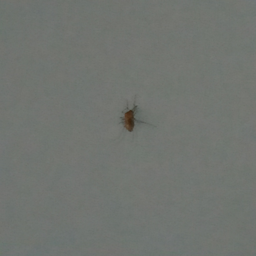

In [11]:
# open image file
pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
pilImg.resize((256, 256))

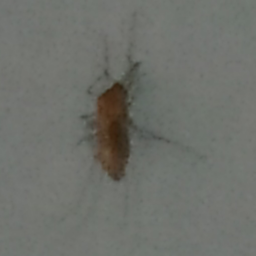

In [12]:
# crop image
bbox = sqrbbox([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], pilImg.size)
pilImg = pilImg.crop(bbox)
pilImg.resize((256, 256))

In [13]:
# transform to torch tensor image
torchImg = torch.unsqueeze(transform(pilImg), dim = 0).to(_device)
torchImg

tensor([[[[-0.1657, -0.1657, -0.1828,  ..., -0.1828, -0.1828, -0.1828],
          [-0.1657, -0.1828, -0.1828,  ..., -0.1828, -0.1828, -0.1828],
          [-0.1828, -0.1828, -0.1828,  ..., -0.1828, -0.1828, -0.1657],
          ...,
          [-0.1486, -0.1486, -0.1828,  ..., -0.1486, -0.1486, -0.1486],
          [-0.1486, -0.1486, -0.1828,  ..., -0.1314, -0.1314, -0.1314],
          [-0.1486, -0.1486, -0.1828,  ..., -0.1314, -0.1314, -0.1314]],

         [[-0.0049, -0.0224, -0.0224,  ...,  0.0301,  0.0301,  0.0301],
          [-0.0049, -0.0224, -0.0224,  ...,  0.0301,  0.0301,  0.0301],
          [-0.0224, -0.0224, -0.0224,  ...,  0.0301,  0.0301,  0.0476],
          ...,
          [ 0.0126,  0.0126,  0.0301,  ...,  0.0126,  0.0126,  0.0126],
          [ 0.0126,  0.0126,  0.0301,  ...,  0.0126,  0.0126,  0.0126],
          [ 0.0126,  0.0126,  0.0301,  ...,  0.0126,  0.0126,  0.0126]],

         [[ 0.1651,  0.1651,  0.1476,  ...,  0.1302,  0.1302,  0.1302],
          [ 0.1651,  0.1476,  

In [ ]:
# inference
output = model(torchImg)

In [42]:
# logits
output, torch.sum(output)

(tensor([[-0.6708, -0.6935, -0.4510, -0.1831, -0.6941,  3.5040, -0.6417]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor(0.1697, device='cuda:0', grad_fn=<SumBackward0>))

In [43]:
# logits are activations, NOT probabilities (can be negative, do not add up to one) !!!
torch.sum(output)

tensor(0.1697, device='cuda:0', grad_fn=<SumBackward0>)

In [47]:
# convert logits to class probabilities
scores = torch.nn.functional.softmax(output, dim = 1)
scores, torch.sum(scores)

(tensor([[0.0139, 0.0136, 0.0173, 0.0227, 0.0136, 0.9046, 0.0143]],
        device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>))

In [49]:
# scores is a gpu tensor, must be transferred to the cpu and converted to numpy
class_probs = scores.cpu().detach().numpy()[0]
class_probs

array([0.01391042, 0.01359871, 0.01733066, 0.02265551, 0.0135906 ,
       0.9045923 , 0.01432178], dtype=float32)

In [51]:
# (hard) class label
print('+++ ground truth: %s' %row.class_label) 
print(' predicted class: %s' %_classes[np.argmax(class_probs)])

+++ ground truth: japonicus-koreicus
 predicted class: japonicus-koreicus


#### batch prediction

In [52]:
def predict(row):
    
    # open image file
    pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
    
    # crop image
    bbox = sqrbbox([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], pilImg.size)
    pilImg = pilImg.crop(bbox)
    
    # transform to torch tensor image
    torchImg = torch.unsqueeze(transform(pilImg), dim = 0).to(_device)
    
    # inference
    output = model(torchImg)
    
    # scores
    output = torch.nn.functional.softmax(output, dim = 1)
    scores = output.cpu().detach().numpy()[0]
    
    # get class predictions
    pred = {k:s for k, s in zip(_classes, scores)}
    pred['img_fName'] = row.img_fName
    pred['pred_label'] = _classes[np.argmax(scores)]
    
    return pred

In [54]:
%%time
outputs = df.apply(predict, axis = 1)

/home/jgarriga/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


CPU times: user 32min 49s, sys: 17.8 s, total: 33min 7s
Wall time: 3min 19s


In [55]:
df_ = pd.merge(df, pd.DataFrame([output for output in outputs]), how = 'inner', on = 'img_fName')

In [56]:
df_.groupby('class_label').pred_label.value_counts()

class_label         pred_label        
aegypti             aegypti                  7
                    culex                    1
                    culiseta                 1
                    japonicus-koreicus       1
albopictus          albopictus            1131
                    aegypti                 25
                    japonicus-koreicus      19
                    culex                   10
                    ??                       9
                    culiseta                 8
anopheles           anopheles               25
                    culex                    7
                    culiseta                 1
culex               culex                 1075
                    culiseta                23
                    anopheles               12
                    ??                      10
                    albopictus               4
                    aegypti                  3
culiseta            culiseta               132
                    c

#### Classification

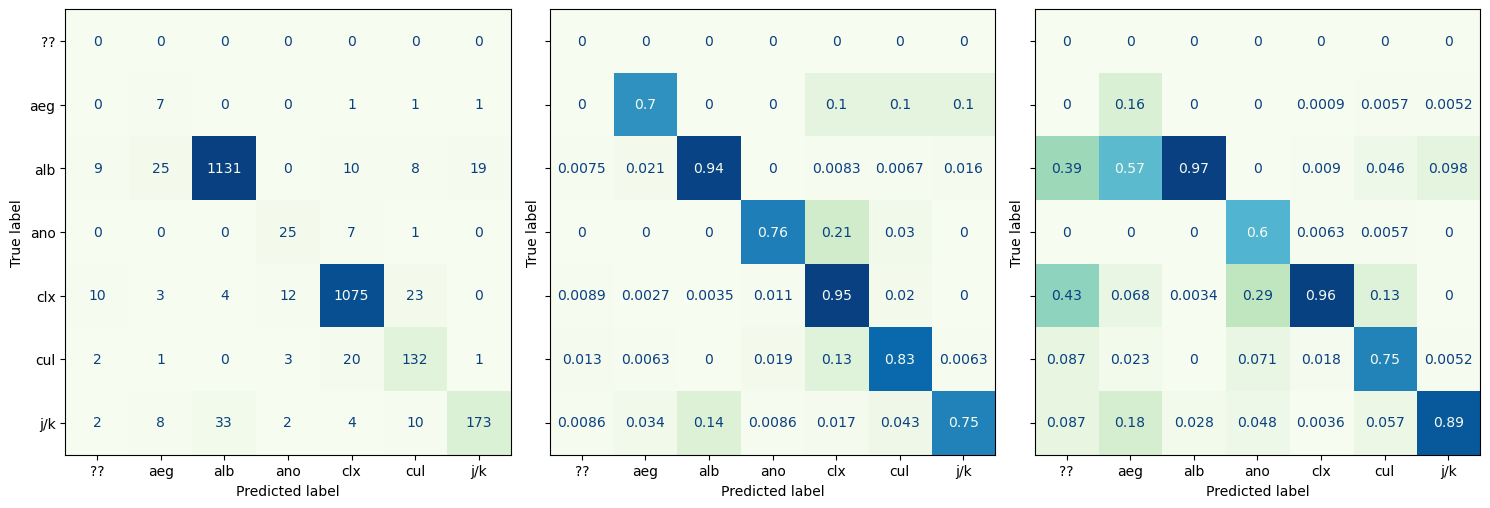

In [57]:
_, axs = plt.subplots(1, 3, figsize = (15, 7), sharey = True)
for i, norm in enumerate([None, 'true', 'pred']):
    ConfusionMatrixDisplay.from_predictions(
        df_.class_label,
        df_.pred_label,
        normalize = norm,
        ax = axs[i],
        display_labels = ['??', 'aeg', 'alb', 'ano', 'clx', 'cul', 'j/k'],
        cmap = 'GnBu',
        colorbar = None
    )
plt.tight_layout()

In [58]:
avrgs = ['macro', 'micro', 'weighted']
pd.DataFrame([prf(df_.class_label, df_.pred_label, average = mode, zero_division = 0)[:3] for mode in avrgs], columns = ['precision', 'recall', 'f-score'], index = avrgs)

,precision,recall,f-score
macro,0.618727,0.704035,0.634442
micro,0.920376,0.920376,0.920376
weighted,0.939775,0.920376,0.928598


#### check predictions

In [60]:
i = -1

+++ 10 test_00010.jpeg - albopictus / albopictus


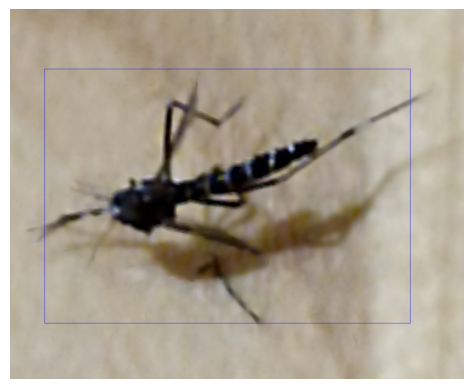

In [71]:
i += 1
row = df_.iloc[i]
pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
imgdrw = ImageDraw.Draw(pilImg)
imgdrw.rectangle([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], outline = 'blue', width = 2)
plt.imshow(pilImg)
plt.axis('off');
print('+++%3d %s - %s / %s' %(i, row.img_fName, row.class_label, row.pred_label))

+++185 - albopictus / ??


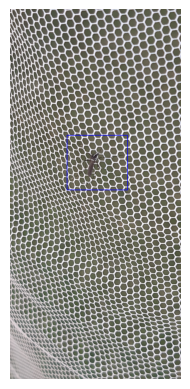

In [73]:
i = 185#, 202, 343
row = df_.iloc[i]
pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
imgdrw = ImageDraw.Draw(pilImg)
imgdrw.rectangle([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], outline = 'blue', width = 8)
plt.imshow(pilImg)
plt.axis('off');
print('+++%3d - %s / %s' %(i, row.class_label, row.pred_label))